# Acknowledgements
https://www.kaggle.com/allunia/pulmonary-dicom-preprocessing - DICOM preprocessing

https://www.kaggle.com/seraphwedd18/pe-detection-with-keras-model-creation - DICOM preprocessing

https://www.kaggle.com/redwankarimsony/rsna-str-pe-gradient-sigmoid-windowing/comments - DICOM windowing

In [1]:
import os
import pydicom
import vtk
import cv2

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import pylab as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from time import time
from random import shuffle, sample, shuffle, randrange
from vtk.util import numpy_support
from statistics import median

In [2]:
# Count the proportion of positive images in the dataset

DATA_ROOT = Path("../input/rsna-str-pulmonary-embolism-detection")
TRAIN_ROOT = DATA_ROOT/"train"

train_csv = pd.read_csv(DATA_ROOT/"train.csv")
image_labels = train_csv[['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID', 'pe_present_on_image']]

negative_indices = list(image_labels.loc[image_labels['pe_present_on_image'] == 0].axes[0])
positive_indices = list(image_labels.loc[image_labels['pe_present_on_image'] == 1].axes[0])
all_indices = negative_indices + positive_indices

print("Total scans:", len(all_indices))
print("Total positive scans:", len(positive_indices))

Total scans: 1790594
Total positive scans: 96540


# **Data Processing**

In [3]:
# Preprocessing the image
# Windowing rescales the image to highlight different parts of the image

def lung_window(img, dcm_fields):
    width = 1600
    length = -600
    window_min = length - (width/2)
    window_max = length + (width/2)
    slope, intercept = dcm_fields
    #img += np.abs(np.min(img))
    img = img * slope + intercept
    img[img < window_min] = window_min
    img[img > window_max] = window_max
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    #print(np.min(img), np.max(img))
    return img

def map_to_gradient(grey_img):
    rainbow_img = np.zeros((grey_img.shape[0], grey_img.shape[1], 3))
    rainbow_img[:, :, 0] = np.clip(4 * grey_img - 2, 0, 1.0) * (grey_img > 0) * (grey_img <= 1.0)
    rainbow_img[:, :, 1] =  np.clip(4 * grey_img * (grey_img <=0.75), 0,1) + np.clip((-4*grey_img + 4) * (grey_img > 0.75), 0, 1)
    rainbow_img[:, :, 2] = np.clip(-4 * grey_img + 2, 0, 1.0) * (grey_img > 0) * (grey_img <= 1.0)
    return rainbow_img

def rainbow_window(img, dcm_fields):
    grey_img = lung_window(img, dcm_fields)
    return map_to_gradient(grey_img)

# **TFRecords**

In [4]:
train_root = "../input/rsna-pe-tfrecords-v2/train/"
all_tfrecords = [train_root+record for record in os.listdir(train_root)]

In [5]:
# TFRecord formats

UNLABELED_TFRECORD_FORMAT = {'SpecificCharacterSet': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'ImageType': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SOPClassUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SOPInstanceUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'Modality': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SliceThickness': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'KVP': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'GantryDetectorTilt': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'TableHeight': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'RotationDirection': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'XRayTubeCurrent': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'Exposure': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'ConvolutionKernel': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'PatientPosition': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'StudyInstanceUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SeriesInstanceUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SeriesNumber': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'InstanceNumber': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'ImagePositionPatient': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'ImageOrientationPatient': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'FrameOfReferenceUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SamplesPerPixel': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'PhotometricInterpretation': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'Rows': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'Columns': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'PixelSpacing': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'BitsAllocated': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'BitsStored': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'HighBit': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'PixelRepresentation': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'WindowCenter': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'WindowWidth': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'RescaleIntercept': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'RescaleSlope': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'image': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None)}

LABELED_TFRECORD_FORMAT = {'SpecificCharacterSet': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'ImageType': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SOPClassUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SOPInstanceUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'Modality': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SliceThickness': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'KVP': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'GantryDetectorTilt': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'TableHeight': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'RotationDirection': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'XRayTubeCurrent': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'Exposure': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'ConvolutionKernel': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'PatientPosition': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'StudyInstanceUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SeriesInstanceUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SeriesNumber': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'InstanceNumber': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'ImagePositionPatient': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'ImageOrientationPatient': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'FrameOfReferenceUID': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'SamplesPerPixel': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'PhotometricInterpretation': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'Rows': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'Columns': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'PixelSpacing': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'BitsAllocated': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'BitsStored': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'HighBit': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'PixelRepresentation': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'WindowCenter': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'WindowWidth': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'RescaleIntercept': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'RescaleSlope': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'negative_exam_for_pe': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'qa_motion': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'qa_contrast': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'flow_artifact': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'rv_lv_ratio_gte_1': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'rv_lv_ratio_lt_1': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'leftsided_pe': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'chronic_pe': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'true_filling_defect_not_pe': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'rightsided_pe': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'acute_and_chronic_pe': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'central_pe': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'indeterminate': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'pe_present_on_image': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'image': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=None)}

In [6]:
# TFRecord data loaders

def read_labeled_tfrecord(example):
    return read_tfrecord(example, LABELED_TFRECORD_FORMAT)

def read_unlabeled_tfrecord(example):
    return read_tfrecord(example, UNLABELED_TFRECORD_FORMAT)

def read_tfrecord(example, record_format):
    try:
        example = tf.io.parse_single_example(example, record_format)
    except:
        print (example)
        raise
    
    data = {k:tf.cast(example[k], record_format[k].dtype) for k in example}
        
    return data

def load_dataset(filenames, batch_size, repeat=True, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord).batch(batch_size, drop_remainder=True)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset.repeat() if repeat else dataset

In [7]:
# Preprocessing function to transform the raw numpy images
# to scaled, windowed, images.
IMAGE_RESOLUTION = (256, 256)

def preprocess(data):
    image = np.array([np.frombuffer(im.numpy(), dtype=np.int16) for im in data['image']]).reshape((batch_size, 512, 512, 1))
    image = tf.image.resize(image, (IMAGE_RESOLUTION[0], IMAGE_RESOLUTION[1])).numpy()
    image = np.squeeze(image, -1)
    
    out_images = np.zeros((batch_size, IMAGE_RESOLUTION[0], IMAGE_RESOLUTION[1], 3))
    
    for i, im in enumerate(image):
        dcm_fields = (int(float(data['RescaleSlope'].numpy()[i].decode())), int(float(data['RescaleIntercept'].numpy()[i].decode())))
        out_images[i] = rainbow_window(image[i], dcm_fields)

    label = data['pe_present_on_image'].numpy()
    label = tf.reshape(label, (batch_size, 1))
    
    return out_images, label

# **Model**

In [8]:
batch_size = 64
learning_rate = 1e-6
#train_steps = 50
image_opt = keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True)

In [9]:
# Model definitions

def get_model():
    image_inp = keras.Input(shape=(IMAGE_RESOLUTION[0], IMAGE_RESOLUTION[1], 3))
    image_model = keras.applications.EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')(image_inp)
    image_model = layers.Dense(1, activation='sigmoid')(image_model)
    image_model = keras.Model(inputs=image_inp, outputs=image_model)
    
    image_model.save_weights("image_weights_initial.h5")
    
    image_model.summary()
    
    return image_model

In [10]:
# Loss weights to apply to the calculated loss
# Ratio of all the training samples to the positive training samples
# Weight of positive images is len(all_indices)/len(positive_indices), otherwise, weight is 1
loss_weights = np.full((batch_size, 1), len(all_indices)/len(positive_indices))

# Loss function with the option of weighting classes
# Uses the defined loss_weights above
def loss_function(labels, logits, weighted=True):
    loss = keras.losses.binary_crossentropy(labels, logits, from_logits=True, label_smoothing=0.05)
    
    if weighted:
        weights = tf.cast(tf.math.greater(labels, 0), tf.float32)*loss_weights
        weights += tf.cast(tf.math.equal(weights, 0), tf.float32)
        weights = tf.reshape(weights, (weights.shape[0],))
        
        loss = tf.math.multiply(loss, weights)

    loss = tf.math.reduce_mean(loss)
    
    return loss

@tf.function
def image_train_step(image_model, image, labels):
    with tf.GradientTape() as tape:
        logits = image_model(image)
        loss = loss_function(labels, logits, weighted=False)
        
    gradients = tape.gradient(loss, image_model.trainable_variables)
    image_opt.apply_gradients(zip(gradients, image_model.trainable_variables))
    
    return loss, logits

@tf.function
def image_eval_step(image_model, image, labels):
    logits = image_model(image)
    loss = loss_function(labels, logits, weighted=False)
    
    return loss, logits

# **TRAIN AND EVALUATE**

**Hyperparameter list:**
* learning_rate = 1e-6
* batch_size = 16
* train_step = 5000 + 10000 + 20000
* trainable_weights = 4,008,829 / 4,050,852

**Dataset summary**
* Total images = 1790594

**Others**
* train step per epoch ~= 106330 steps
* train_size = 95%
* test_size = 5%

In [11]:
def plot_metrics(step, metrics):
    """
    metrics = [loss, auc]
    """
    figure = plt.figure(figsize=(30,7))
    ax1, ax2 = figure.subplots(1,2)
   
    ax1.plot(step, metrics[0], label='Loss')
    ax1.title.set_text('Loss')
    ax2.plot(step, metrics[1], label='AUC_PR')
    ax2.title.set_text('AUC_PR')
    
    #plt.legend(loc="upper left")

In [12]:
def split_train_validation(tfrecords, train_proportion = 95):
    
    train_size = len(tfrecords) * train_proportion // 100
    print(f'Train size: {train_size}')
    print(f'Validation_size: {len(tfrecords)-train_size}')
    
    shuffle(tfrecords)
    
    train_files = tfrecords[:train_size]
    validation_files = tfrecords[train_size:]
    
    return train_files, validation_files

In [13]:
def tfrecords_train(train_files, image_model, training_steps):
    
    loss_met = keras.metrics.Mean()
    auc_pr_met = keras.metrics.AUC(curve='PR')
    
    loss_history = list()
    auc_pr_history = list()
    train_step_history = list()
    
    train_dataset = load_dataset(train_files, batch_size, repeat=False)
    
    count = 0
    stop = False
    
    while True:
        for n, data in enumerate(train_dataset):
            # preprocessing before feeding to model
            image, label = preprocess(data)

            # feed-forward and backprop
            loss, logits = image_train_step(image_model, image, label)

            loss_met(loss)
            auc_pr_met(label, logits)

            print(f"Training data point {n+1} average loss, auc_pr: {loss_met.result()}, {auc_pr_met.result()}    \r", end='')
            
            if count%10 == 0: # reset every 10 steps instead of 1 to compress the noise of mini-batch gradient descent
                
                loss_history.append(loss_met.result().numpy())
                auc_pr_history.append(auc_pr_met.result().numpy())
                train_step_history.append(count)
                
                loss_met.reset_states()
                auc_pr_met.reset_states()
            
            count = count+1

            if count >= training_steps:
                stop = True
                break
        
        #print('------------------------------------------------------------------------------')
        image_model.save_weights(f"image_weights_{count}.h5")
        
        if stop:
            break
    
    return loss_history, auc_pr_history, train_step_history
    

In [14]:
def tfrecords_evaluate(validation_files, image_model):
    loss_met = keras.metrics.Mean()
    auc_pr_met = keras.metrics.AUC(curve='PR')
    
    validation_dataset = load_dataset(validation_files, batch_size, repeat=False)
    
    for n, data in enumerate(validation_dataset):
        # preprocessing before feeding to model
        image, label = preprocess(data)
    
        # feed-forward and backprop
        loss, logits = image_eval_step(image_model, image, label)

        loss_met(loss)
        auc_pr_met(label, logits)
        
    print(f"Validation average loss, auc_pr: {loss_met.result()}, {auc_pr_met.result()}")

In [15]:
# setting up
keras.backend.clear_session()
image_model = get_model()
train_files, validation_files = split_train_validation(all_tfrecords, train_proportion=95)

16711680/16705208 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 4,008,829
Non-trainable params: 42,023
_________________________________________________________________
Train size: 3038
Validation_size: 160


Total time 9109.457636356354


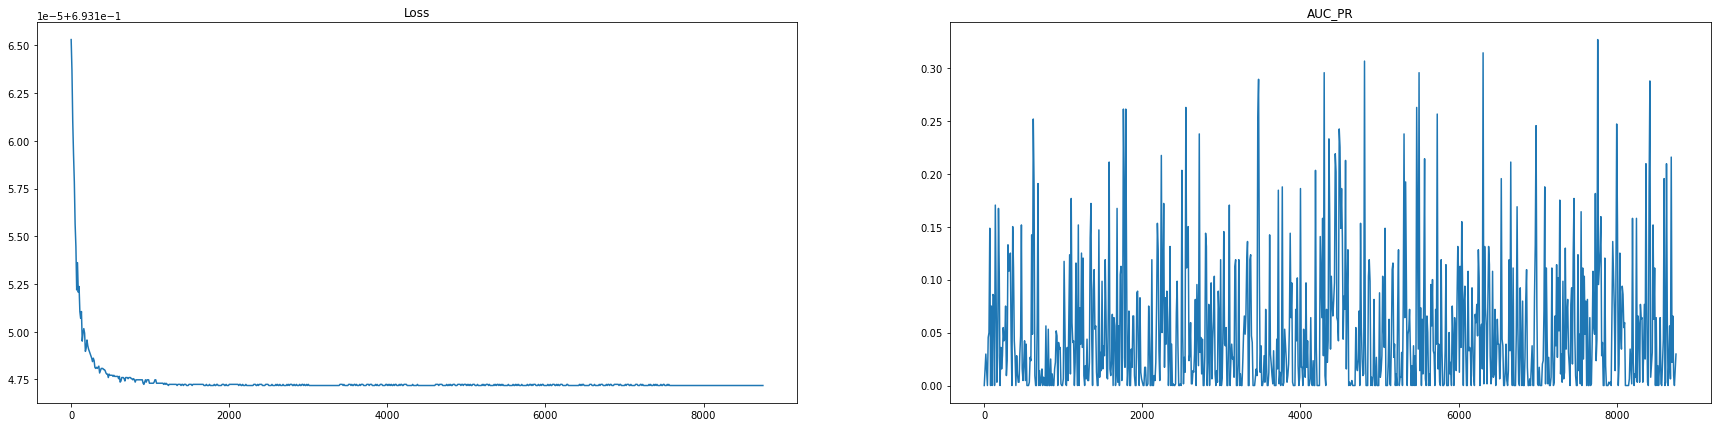

In [16]:
training_step = 8760
# train
image_model.load_weights("../input/unweighted-loss-weight/image_weights_8740.h5")
t1 = time()
history = tfrecords_train(train_files, image_model, training_steps=training_step)
t2 = time()
print(f'Total time {t2-t1}')
plot_metrics(history[2],[history[0], history[1]])

In [17]:
# evaluate
image_model.load_weights("image_weights_8760.h5")
tfrecords_evaluate(validation_files, image_model)

Validation average loss, auc_pr: 0.6931602358818054, 0.054040178656578064
